In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
    


In [82]:
def load_data():
    """Load and preprocess the data"""
    #load data
    constructors = pd.read_csv('constructors.csv')
    constructor_standings = pd.read_csv('constructor_standings.csv')
    races = pd.read_csv('races.csv')
    pit_stops = pd.read_csv('pit_stops.csv')
    status = pd.read_csv('status.csv')
    results = pd.read_csv('results.csv')


#merge constructors standings with races and constructors
    constructor_standings = constructor_standings.merge(races[['raceId', 'year', 'round']], on = 'raceId').merge(constructors[['constructorId', 'name', 'nationality']], on = 'constructorId')

    #merge pit stops with races and constructors
    pit_stops = pit_stops.merge(
        races[['raceId', 'year', 'round']], on='raceId').merge(
        results[['raceId', 'driverId', 'constructorId']], on=['raceId', 'driverId']
    ).merge(
        constructors[['constructorId', 'name']], on='constructorId'
    )


    # Merge status with races and constructors
    results_with_status = results.merge(
    status, 
    left_on='statusId', 
    right_on='statusId'
    ).merge(
    races[['raceId', 'year', 'round']], 
    on='raceId'
    ).merge(
    constructors[['constructorId', 'name']], 
    on='constructorId'
    )
    
    return constructors, constructor_standings, pit_stops, results_with_status, races

    

In [83]:
def analyze_team_performance_evolution(constructor_standings):
    """Analyze team performance evolution over time"""
    # Calculate yearly performance metrics
    yearly_performance = constructor_standings.groupby(['year', 'name']).agg({
        'points': 'sum',
        'wins': 'sum',
        'position': 'mean'
    }).reset_index()
    
    # Calculate rolling average of points for each team
    yearly_performance['rolling_points'] = yearly_performance.groupby('name')['points'].transform(
        lambda x: x.rolling(window=3, min_periods=1).mean()
    )
    
    return yearly_performance


In [84]:
def analyze_team_reliability(status):
    """Analyze team reliability using status data"""
    # Count different status types for each team
    reliability_data = status.groupby(['name', 'status']).size().reset_index(name='count')
    
    # Calculate reliability score (percentage of finishes)
    total_races = status.groupby('name').size().reset_index(name='total_races')
    finishes = status[status['status'] == 'Finished'].groupby('name').size().reset_index(name='finishes')
    
    reliability = total_races.merge(finishes, on='name', how='left')
    reliability['reliability_score'] = reliability['finishes'] / reliability['total_races']
    
    return reliability

In [85]:
def analyze_team_strategies(pit_stops):
    """Analyze team strategies using pit stop data"""
    # Calculate average pit stop duration per team
    pit_stop_performance = pit_stops.groupby('name').agg({
        'duration': 'mean',
        'stop': 'count'
    }).reset_index()
    
    # Calculate pit stop frequency (average stops per race)
    races_per_team = pit_stops.groupby('name')['raceId'].nunique().reset_index()
    pit_stop_performance = pit_stop_performance.merge(races_per_team, on='name')
    pit_stop_performance['stops_per_race'] = pit_stop_performance['stop'] / pit_stop_performance['raceId']
    
    return pit_stop_performance

In [86]:
def analyze_constructor_dominance(constructor_standings):
    """Analyze constructor dominance periods"""
    # Calculate championship points and positions
    yearly_championships = constructor_standings.groupby(['year', 'name']).agg({
        'points': 'sum',
        'wins': 'sum'
    }).reset_index()
    
    # Identify dominant periods (teams with >40% of total points in a season)
    total_points_per_year = yearly_championships.groupby('year')['points'].sum().reset_index()
    yearly_championships = yearly_championships.merge(total_points_per_year, on='year', suffixes=('', '_total'))
    yearly_championships['points_share'] = yearly_championships['points'] / yearly_championships['points_total']
    
    dominant_periods = yearly_championships[yearly_championships['points_share'] > 0.4]
    
    return yearly_championships, dominant_periods

In [87]:
def plot_performance_evolution(yearly_performance):
    """Plot team performance evolution"""
    plt.figure(figsize=(15, 8))
    
    # Plot top 5 teams by total points
    top_teams = yearly_performance.groupby('name')['points'].sum().nlargest(5).index
    
    for team in top_teams:
        team_data = yearly_performance[yearly_performance['name'] == team]
        plt.plot(team_data['year'], team_data['rolling_points'], label=team, marker='o')
    
    plt.title('Team Performance Evolution (3-Year Rolling Average)')
    plt.xlabel('Year')
    plt.ylabel('Points')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('team_performance_evolution.png')

In [88]:
def plot_reliability_analysis(reliability):
    """Plot team reliability analysis"""
    plt.figure(figsize=(12, 6))
    
    # Plot top 10 teams by reliability score
    top_reliable = reliability.nlargest(10, 'reliability_score')
    sns.barplot(data=top_reliable, x='reliability_score', y='name')
    
    plt.title('Top 10 Most Reliable Teams')
    plt.xlabel('Reliability Score (Finish Rate)')
    plt.ylabel('Team')
    plt.tight_layout()
    plt.savefig('team_reliability.png')

In [89]:
def plot_strategy_analysis(pit_stop_performance):
    """Plot team strategy analysis"""
    plt.figure(figsize=(12, 6))
    
    # Plot pit stop duration vs frequency
    sns.scatterplot(data=pit_stop_performance, x='stops_per_race', y='duration', size='raceId', alpha=0.6)
    
    plt.title('Team Pit Stop Strategy Analysis')
    plt.xlabel('Average Stops per Race')
    plt.ylabel('Average Pit Stop Duration (seconds)')
    plt.tight_layout()
    plt.savefig('team_strategy.png')


Analyzing team performance evolution...

Analyzing team reliability...

Top 10 Most Reliable Teams:
               name  reliability_score
31            Brawn           0.941176
139        Mercedes           0.819018
166        Red Bull           0.720812
155        Phillips           0.714286
144           Moore           0.666667
17       BMW Sauber           0.657143
69          Epperly           0.647059
14     Aston Martin           0.554974
6    Alpine F1 Team           0.550000
73          Ferrari           0.542025

Analyzing team strategies...


TypeError: agg function failed [how->mean,dtype->object]

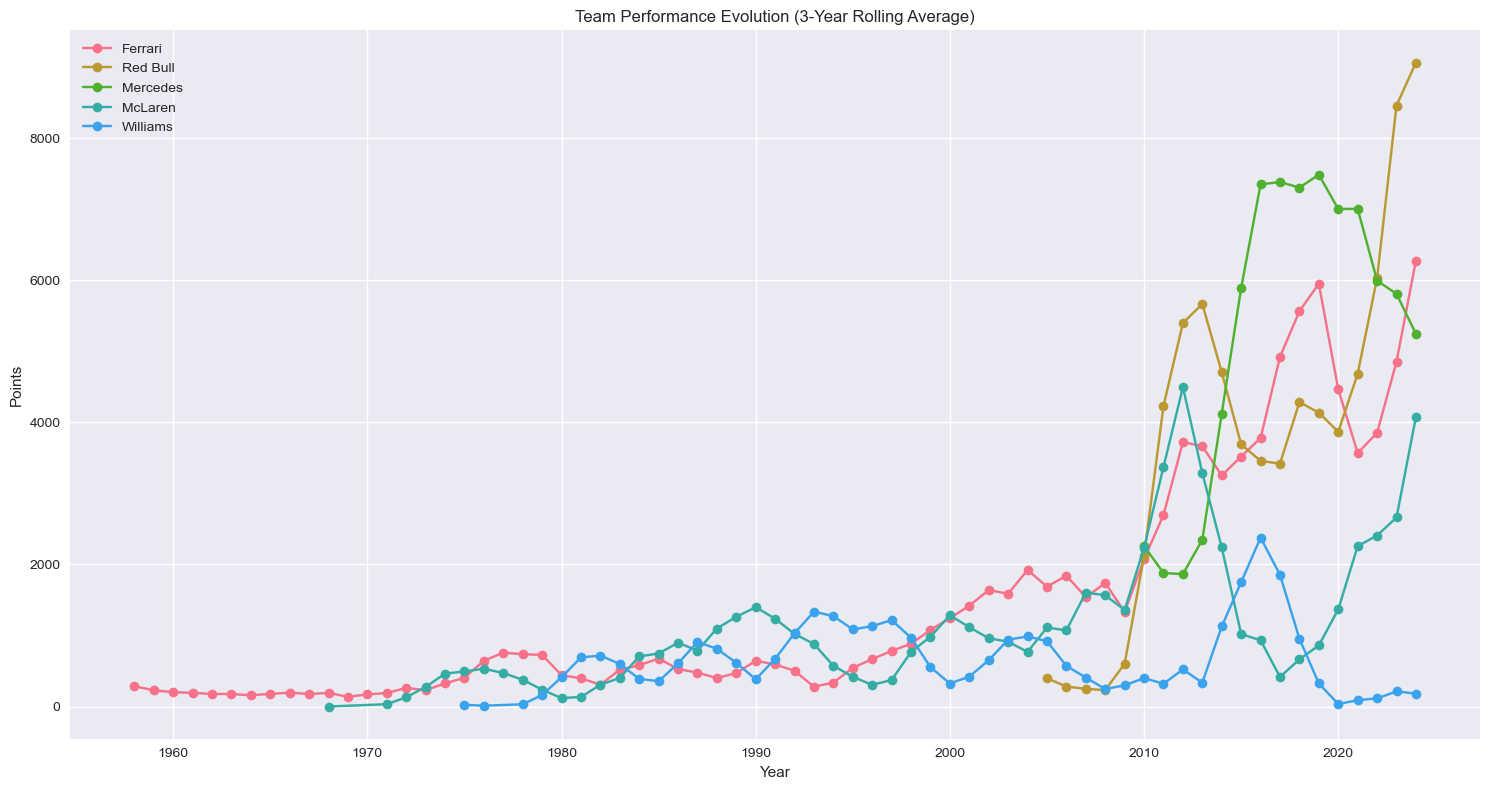

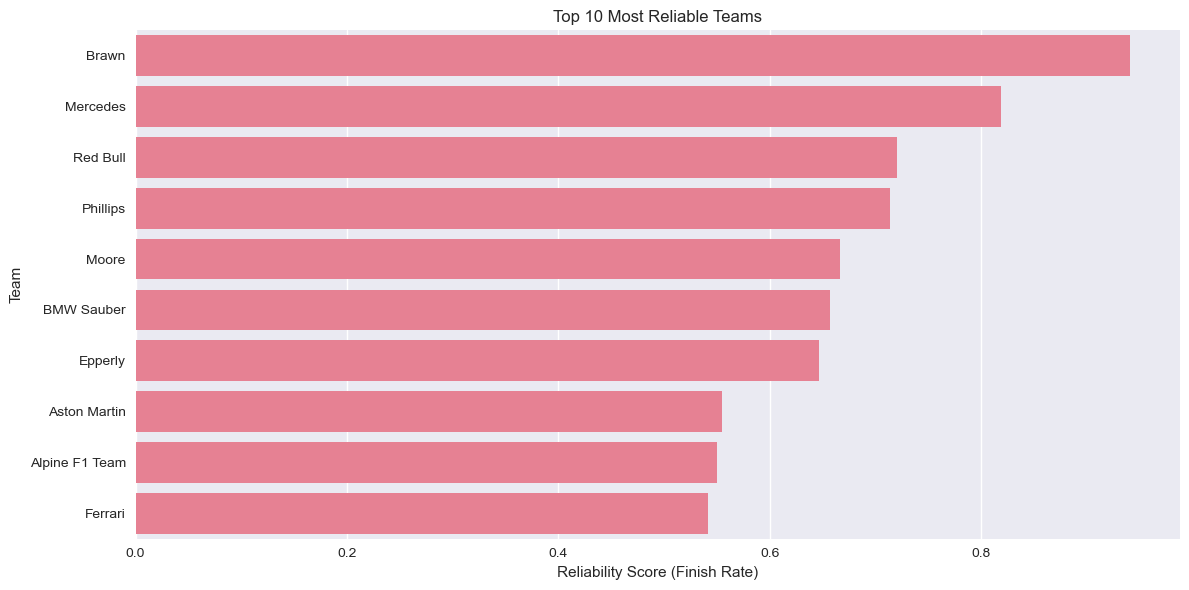

In [90]:
def main():
    # Load data
    constructors, constructor_standings, pit_stops, status, races = load_data()
    
    # 1. Team Performance Evolution
    print("\nAnalyzing team performance evolution...")
    yearly_performance = analyze_team_performance_evolution(constructor_standings)
    plot_performance_evolution(yearly_performance)
    
    # 2. Team Reliability Analysis
    print("\nAnalyzing team reliability...")
    reliability = analyze_team_reliability(status)
    print("\nTop 10 Most Reliable Teams:")
    print(reliability.nlargest(10, 'reliability_score')[['name', 'reliability_score']])
    plot_reliability_analysis(reliability)
    
    # 3. Team Strategy Analysis
    print("\nAnalyzing team strategies...")
    pit_stop_performance = analyze_team_strategies(pit_stops)
    print("\nTeam Pit Stop Performance:")
    print(pit_stop_performance[['name', 'duration', 'stops_per_race']])
    plot_strategy_analysis(pit_stop_performance)
    
    # 4. Constructor Dominance Analysis
    print("\nAnalyzing constructor dominance periods...")
    yearly_championships, dominant_periods = analyze_constructor_dominance(constructor_standings)
    print("\nDominant Periods (Teams with >40% of points in a season):")
    print(dominant_periods[['year', 'name', 'points_share', 'wins']])

if __name__ == "__main__":
    main() 